In [1]:
import kagglehub
import torch
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import ViTForImageClassification

# Skin Cancer

In [2]:
# Download latest version
path_skin = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

print("Path to dataset files:", path_skin)

100%|██████████| 98.7M/98.7M [00:05<00:00, 19.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1


In [3]:
# Path to your dataset
train_path = path_skin+'/melanoma_cancer_dataset/train'
test_path = path_skin+'/melanoma_cancer_dataset/test'

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),         # Convert to PyTorch Tensor
])

# Load training data
train_dataset = datasets.ImageFolder(root=train_path, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load testing data
test_dataset = datasets.ImageFolder(root=test_path, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Class names
classes = train_dataset.classes
print(f"Classes: {classes}")

Classes: ['benign', 'malignant']


In [5]:
# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(classes)  # Set the number of output labels
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.2021
Epoch 2/10, Loss: 0.1445
Epoch 3/10, Loss: 0.1156
Epoch 4/10, Loss: 0.1097
Epoch 5/10, Loss: 0.0826
Epoch 6/10, Loss: 0.0659
Epoch 7/10, Loss: 0.0450
Epoch 8/10, Loss: 0.0533
Epoch 9/10, Loss: 0.0408
Epoch 10/10, Loss: 0.0332


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 93.00%


In [8]:
# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)

        # Collect the true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


In [9]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names (these should be the same as the ones used during training)
class_names = train_dataset.classes


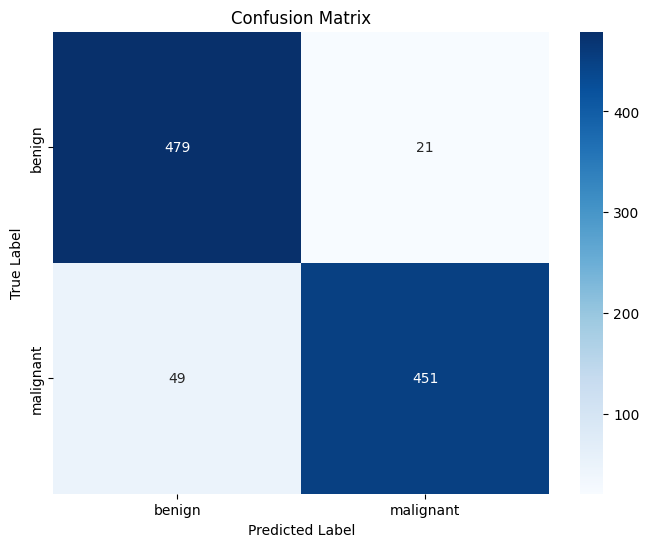

In [10]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [11]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

      benign       0.91      0.96      0.93       500
   malignant       0.96      0.90      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [12]:
torch.save(model.state_dict(), 'skin_cancer_pretrained.pth')

---

#Facial Skin Diseases

In [13]:
# Download latest version
path_facial = kagglehub.dataset_download("shwetakk/facial-skin-disease")

print("Path to dataset files:", path_facial)

100%|██████████| 8.08M/8.08M [00:01<00:00, 5.66MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shwetakk/facial-skin-disease/versions/1


In [14]:
# Replace 'directory_path' with your directory's path
directory_path = path_facial+'/facial-skin-diseases'

# List all files and directories
contents = os.listdir(directory_path)
print(contents)

['test', 'train']


In [15]:
# Path to your dataset
train_path = path_facial+'/facial-skin-diseases/train'
test_path = path_facial+'/facial-skin-diseases/test'

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),         # Convert to PyTorch Tensor
])

# Load training data
train_dataset = datasets.ImageFolder(root=train_path, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load testing data
test_dataset = datasets.ImageFolder(root=test_path, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Class names
classes = train_dataset.classes
print(f"Classes: {classes}")

Classes: ['acne', 'eksim', 'herpes', 'panu', 'rosacea']


In [17]:
# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(classes)  # Set the number of output labels
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 1.3857
Epoch 2/5, Loss: 0.7850
Epoch 3/5, Loss: 0.4311
Epoch 4/5, Loss: 0.2655
Epoch 5/5, Loss: 0.1795


In [19]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 90.00%


In [20]:
# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)

        # Collect the true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


In [21]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names (these should be the same as the ones used during training)
class_names = train_dataset.classes


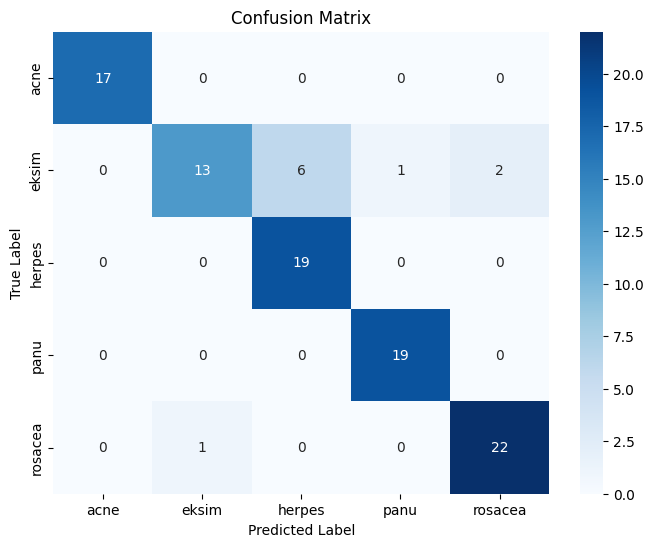

In [22]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [23]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00        17
       eksim       0.93      0.59      0.72        22
      herpes       0.76      1.00      0.86        19
        panu       0.95      1.00      0.97        19
     rosacea       0.92      0.96      0.94        23

    accuracy                           0.90       100
   macro avg       0.91      0.91      0.90       100
weighted avg       0.91      0.90      0.89       100



In [24]:
torch.save(model.state_dict(), 'facial_diseases_pretrained.pth')

---

# Hair Diseases

In [25]:
# Download latest version
path_hair = kagglehub.dataset_download("sundarannamalai/hair-diseases")

print("Path to dataset files:", path_hair)

100%|██████████| 564M/564M [00:26<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sundarannamalai/hair-diseases/versions/1


In [26]:
# Replace 'directory_path' with your directory's path
directory_path = path_hair+'/Hair Diseases - Final'

# List all files and directories
contents = os.listdir(directory_path)
print(contents)

['test', 'train', 'val']


In [27]:
# Path to your dataset
train_path = path_hair+'/Hair Diseases - Final/train'
test_path = path_hair+'/Hair Diseases - Final/test'

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),         # Convert to PyTorch Tensor
])

# Load training data
train_dataset = datasets.ImageFolder(root=train_path, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load testing data
test_dataset = datasets.ImageFolder(root=test_path, transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
# Class names
classes = train_dataset.classes
print(f"Classes: {classes}")

Classes: ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']


In [29]:
# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(classes)  # Set the number of output labels
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.4495
Epoch 2/5, Loss: 0.0327
Epoch 3/5, Loss: 0.0120
Epoch 4/5, Loss: 0.0065
Epoch 5/5, Loss: 0.0041


In [31]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 100.00%


In [32]:
# Set the model to evaluation mode
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)

        # Collect the true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


In [33]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names (these should be the same as the ones used during training)
class_names = train_dataset.classes


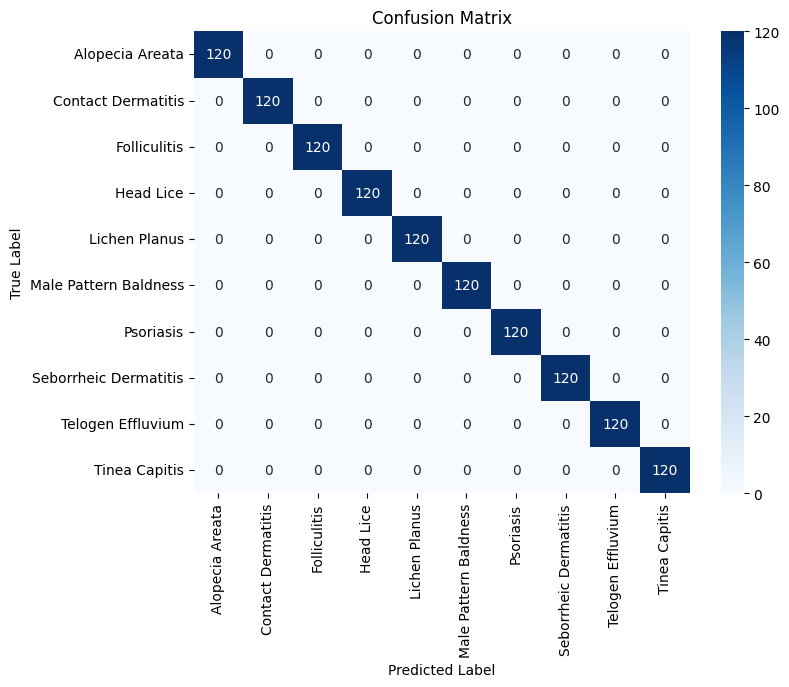

In [34]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [35]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                       precision    recall  f1-score   support

      Alopecia Areata       1.00      1.00      1.00       120
   Contact Dermatitis       1.00      1.00      1.00       120
         Folliculitis       1.00      1.00      1.00       120
            Head Lice       1.00      1.00      1.00       120
        Lichen Planus       1.00      1.00      1.00       120
Male Pattern Baldness       1.00      1.00      1.00       120
            Psoriasis       1.00      1.00      1.00       120
Seborrheic Dermatitis       1.00      1.00      1.00       120
    Telogen Effluvium       1.00      1.00      1.00       120
        Tinea Capitis       1.00      1.00      1.00       120

             accuracy                           1.00      1200
            macro avg       1.00      1.00      1.00      1200
         weighted avg       1.00      1.00      1.00      1200



In [36]:
torch.save(model.state_dict(), 'hair_diseases_pretrained.pth')